In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from sklearn.preprocessing import label_binarize
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D,Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet_v2 import ResNet152V2

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 73 bytes


In [3]:
!pip install opendatasets

In [4]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?select=Training')

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


100%|██████████| 149M/149M [00:00<00:00, 640MB/s]


In [5]:
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [6]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 50

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)

# Apenas rescale para teste/validação
test_datagen = ImageDataGenerator(rescale=1./255)

# Geradores
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training',
                                                    shuffle=True)

#
validation_generator = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation',
                                                         shuffle=False)

# Gerador de teste
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=IMG_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [8]:
class_labels = list(train_generator.class_indices.keys())
num_classes = len(class_labels)

# número de exemplos para visualizar por classe
samples_per_class = 3

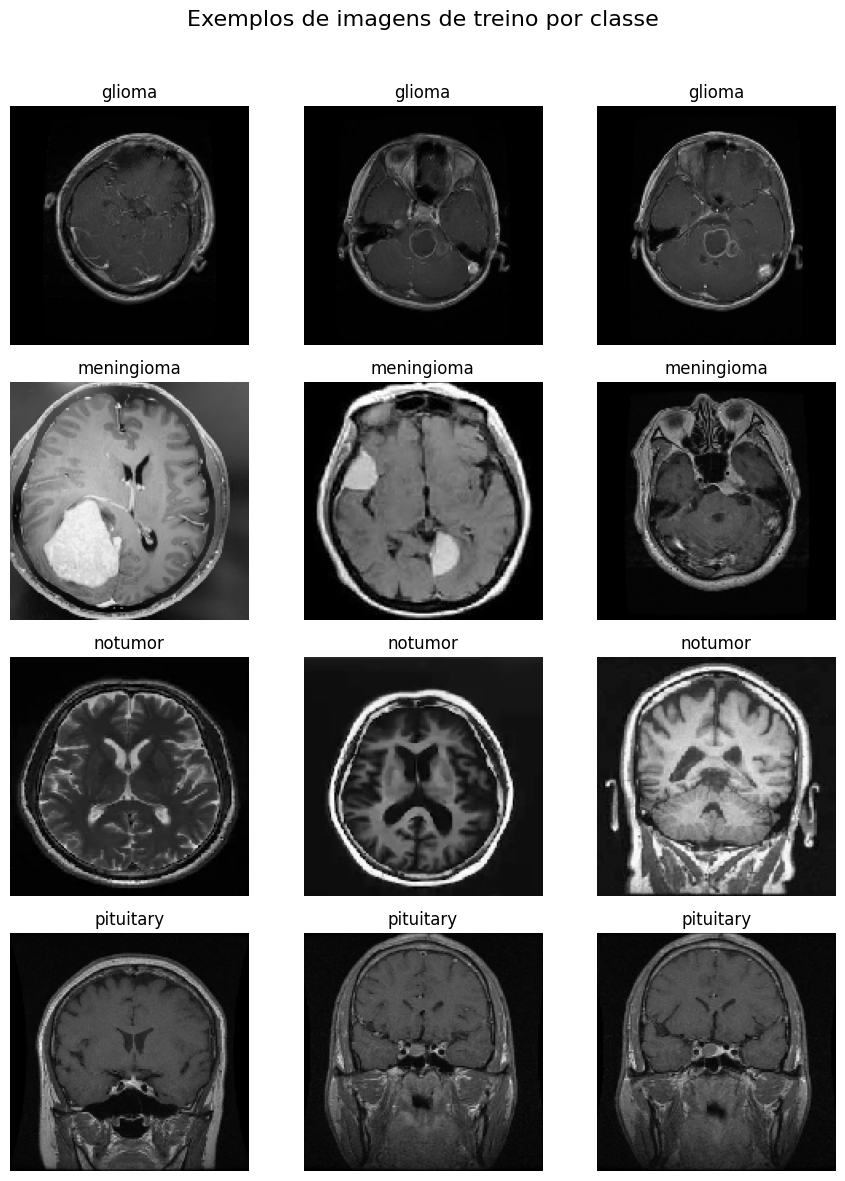

In [9]:
plt.figure(figsize=(samples_per_class * 3, num_classes * 3))
for idx, class_label in enumerate(class_labels):

    # Encontrar filepaths correspondentes à classe
    class_index = train_generator.class_indices[class_label]

    # Obtém todos os caminhos e classes do iterator
    filepaths = train_generator.filepaths
    classes = train_generator.classes

    # Filtra índices para a classe
    indices = [i for i, c in enumerate(classes) if c == class_index]

    # Seleciona primeiros exemplos
    selected = indices[:samples_per_class]

    #
    for j, i in enumerate(selected):
        img_path = filepaths[i]
        img = load_img(img_path, target_size=IMG_SIZE)
        img_arr = img_to_array(img) / 255.0
        ax = plt.subplot(num_classes, samples_per_class, idx * samples_per_class + j + 1)
        ax.imshow(img_arr.astype('float32'))
        ax.set_title(f'{class_label}')
        ax.axis('off')

plt.suptitle('Exemplos de imagens de treino por classe', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

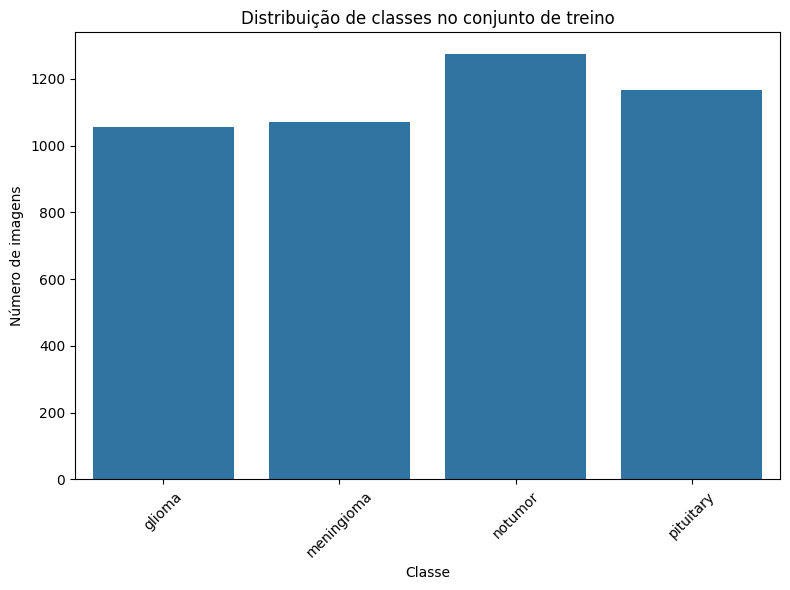

In [10]:
class_labels = list(train_generator.class_indices.keys())
train_classes = train_generator.classes
plt.figure(figsize=(8, 6))
# Mapeia classes para labels legíveis
sns.countplot(x=[class_labels[c] for c in train_classes])
plt.title('Distribuição de classes no conjunto de treino')
plt.xlabel('Classe')
plt.ylabel('Número de imagens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras import callbacks
callbacks = [
    # Early Stopping
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True,
        verbose=1
    ),

    # Learning Rate Reduction
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

In [16]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,700,036 (21.74 MB)

 Trainable params: 5,699,076 (21.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 356ms/step - accuracy: 0.5044 - loss: 4.2369 - val_accuracy: 0.2962 - val_loss: 3.0127 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - accuracy: 0.5725 - loss: 0.9979 - val_accuracy: 0.3295 - val_loss: 3.3223 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.6448 - loss: 0.9304 - val_accuracy: 0.3970 - val_loss: 1.8524 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 284ms/step - accuracy: 0.6794 - loss: 0.8095 - val_accuracy: 0.5688 - val_loss: 1.3141 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - accuracy: 0.7098 - loss: 0.7362 - val_accuracy: 0.6564 - val_loss: 1.0530 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 279ms/step - accuracy: 0.7257 - loss: 0.6805 - val_accuracy: 0.6845 - val_loss: 0.9075 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - accuracy: 0.7

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.7350 - loss: 1.0960
Test loss: 0.7272, Test accuracy: 0.8261


In [19]:
def check_metrics(history, figure_name):

    train = history.history[f'{figure_name}']
    val = history.history[f'val_{figure_name}']

    epochs = range(1, len(train) + 1)
    plt.plot(epochs, train, 'b', label=f'Training {figure_name}', color='orange')
    plt.plot(epochs, val, 'b', label=f'Validation {figure_name}')
    plt.title(f'Training and Validation {figure_name}')
    plt.xlabel('Epochs')
    plt.ylabel(f'{figure_name}')
    plt.legend()
    plt.show()

In [20]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


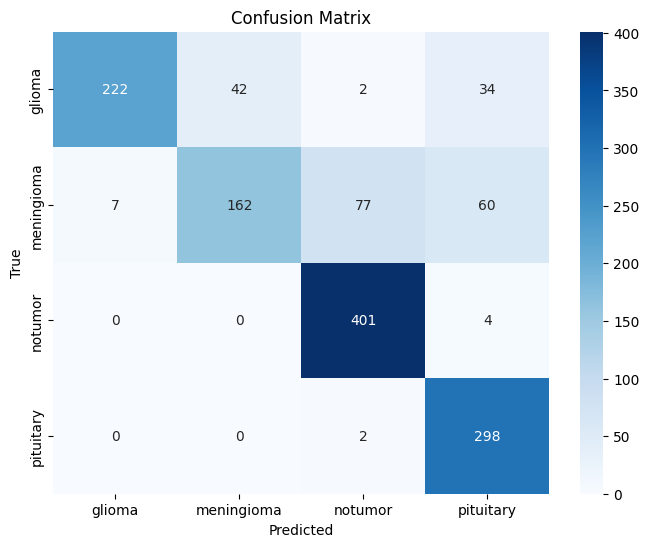

In [21]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      glioma       0.97      0.74      0.84       300
  meningioma       0.79      0.53      0.64       306
     notumor       0.83      0.99      0.90       405
   pituitary       0.75      0.99      0.86       300

    accuracy                           0.83      1311
   macro avg       0.84      0.81      0.81      1311
weighted avg       0.84      0.83      0.82      1311



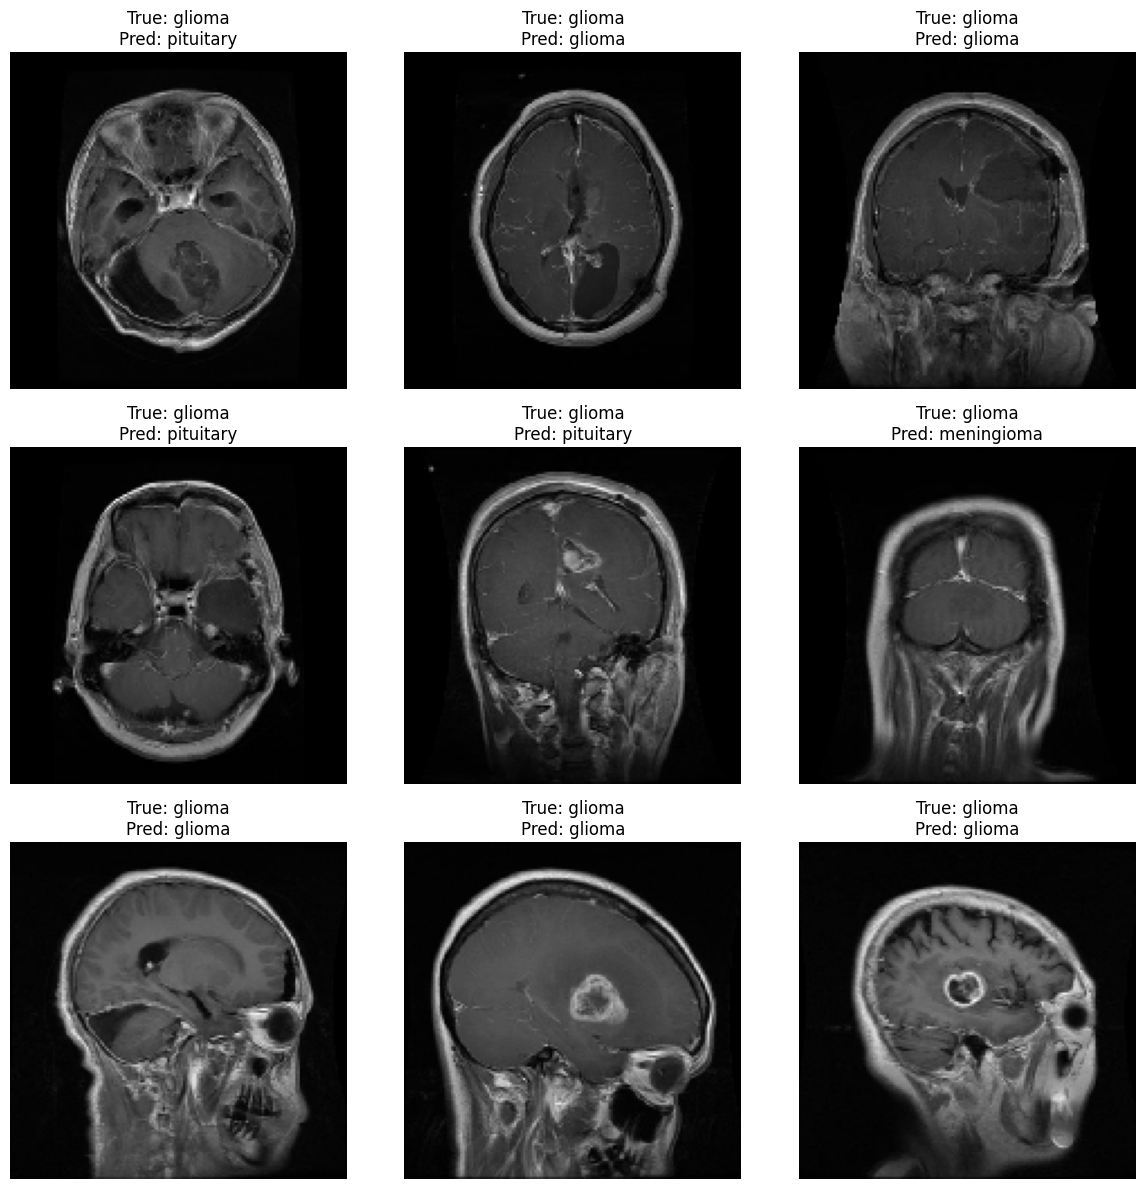

In [23]:
num_rows = 3
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
axes = axes.flatten()

# Garantir que há imagens suficientes no teste
total_test = len(test_generator.filenames)
for i, ax in enumerate(axes):
    if i >= total_test:
        break
    img_batch, label_batch = test_generator[i]
    img = img_batch[0]
    true_label = np.argmax(label_batch[0])
    pred_label = predicted_classes[i]
    ax.imshow(img)
    ax.set_title(f'True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
def IV3():
    model = Sequential()

    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu'))

    #output
    model.add(Dense(len(class_labels), activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [27]:
model_IV3 = IV3()
model_IV3.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 3, 3, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,211,876 (115.25 MB)

 Trainable params: 8,409,092 (32.08 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [28]:
history_IV3 = model_IV3.fit(train_generator,
              epochs=EPOCHS,
              validation_data=validation_generator,callbacks=callbacks)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 88s 461ms/step - accuracy: 0.6555 - loss: 3.6554 - val_accuracy: 0.6731 - val_loss: 0.9227 - learning_rate: 0.0010
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 471ms/step - accuracy: 0.8353 - loss: 0.4317 - val_accuracy: 0.7511 - val_loss: 0.6581 - learning_rate: 0.0010
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 401ms/step - accuracy: 0.8564 - loss: 0.3841 - val_accuracy: 0.7511 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.8631 - loss: 0.3529 - val_accuracy: 0.7765 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 416ms/step - accuracy: 0.8807 - loss: 0.3357 - val_accuracy: 0.7739 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 335ms/step - accuracy: 0.8827 - loss: 0.3082 - val_accuracy: 0.7634 - val_loss: 0.5992 - learning_rate: 0.0010
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 274ms/step - accuracy: 0.8

In [29]:
loss_IV3_train, accuracy_IV3_train = model_IV3.evaluate(train_generator)

143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 231ms/step - accuracy: 0.9556 - loss: 0.1197


In [30]:
loss_IV3_val, accuracy_IV3_val = model_IV3.evaluate(validation_generator)

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.8572 - loss: 0.4096


In [12]:
def VGG_19():
    model = Sequential()

    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu'))

    # Output layer
    model.add(Dense(len(class_labels), activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [13]:
model_VGG19 = VGG_19()
model_VGG19.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 4, 4, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │        16,388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,142,020 (84.47 MB)

 Trainable params: 2,117,636 (8.08 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
history_VGG19 = model_VGG19.fit(train_generator,
                epochs=EPOCHS,
                validation_data=validation_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
  6/143 ━━━━━━━━━━━━━━━━━━━━ 20:07 9s/step - accuracy: 0.1914 - loss: 1.7451

In [ ]:
loss_VGG19_train, accuracy_VGG19_train = model_VGG19.evaluate(train_generator)

In [ ]:
loss_VGG19_val, accuracy_VGG19_val = model_VGG19.evaluate(validation_generator)

In [ ]:
def ResNet152_V2():
    model = Sequential()

    base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu'))

    # Output layer
    model.add(Dense(len(class_labels), activation='softmax'))

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_ResNet = ResNet152_V2()
model_ResNet.summary()

In [ ]:
history_ResNet = model_ResNet.fit(train_generator,
                 epochs=EPOCHS,
                 validation_data=validation_generator,
                 batch_size=128)

In [ ]:
loss_ResNet_val, accuracy_ResNet_val = model_ResNet.evaluate(validation_generator)

In [ ]:
loss_ResNet_train, accuracy_ResNet_train = model_ResNet.evaluate(train_generator)

In [ ]:
selection_evaluation = {
    "Inception V3": [loss_IV3_train, accuracy_IV3_train, loss_IV3_val, accuracy_IV3_val],
    "VGG19": [loss_VGG19_train, accuracy_VGG19_train, loss_VGG19_val, accuracy_VGG19_val],
    "ResNet152V2": [loss_ResNet_train, accuracy_ResNet_train, loss_ResNet_val, accuracy_ResNet_val],
}

selection_evaluation_df = pd.DataFrame(selection_evaluation, index = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

selection_evaluation_df

In [ ]:
def ResNet152_V2_ft():
    model = Sequential()

    base_model = ResNet152V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-30:]:
        layer.trainable = True

    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(4096, activation='relu'))

    model.add(Dense(len(class_labels)), activation='softmax')

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model_ResNet_ft = ResNet152_V2_ft()
model_ResNet_ft.summary()

In [ ]:
history_ResNet_ft = model_ResNet_ft.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    batch_size=128)

In [ ]:
loss_ResNet_ft_val, accuracy_ResNet_ft_val = model_ResNet_ft.evaluate(validation_generator)

In [ ]:
loss_ResNet_ft_train, accuracy_ResNet_ft_train = model_ResNet_ft.evaluate(train_generator)

In [ ]:
check_metrics(history_ResNet_ft, 'loss')
check_metrics(history_ResNet_ft, 'accuracy')

In [ ]:
result_ResNet_ft = model_ResNet_ft.predict(test_generator,verbose = 0)

y_pred_ResNet_ft = np.argmax(result_ResNet_ft, axis = 1)

y_true_ResNet_ft = test_generator.classes

loss_ResNet_ft_test, accuracy_ResNet_ft_test, = model_ResNet_ft.evaluate(test_generator,verbose = 0)

print('The accuracy of the model for testing data is:',accuracy_ResNet_ft_test)
print('The Loss of the model for testing data is:',loss_ResNet_ft_test)

In [ ]:
print(classification_report(y_true_ResNet_ft, y_pred_ResNet_ft, target_names = class_labels)

In [ ]:
test_evaluation = {
    "ResNet152V2": [loss_ResNet_train, accuracy_ResNet_train, loss_ResNet_val, accuracy_ResNet_val],
    "ResNet152V2 (fine-tuned)": [loss_ResNet_ft_train, accuracy_ResNet_ft_train, loss_ResNet_ft_val, accuracy_ResNet_ft_val],
}

test_evaluation_df = pd.DataFrame(test_evaluation, index = ["Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

test_evaluation_df